In [5]:
from backtesting_engine import BacktestEngine
from Bardata import BarData
import sys
from typing import List



In [6]:
class sample_strategy(BacktestEngine):
    def __init__(self, config):
        super().__init__(config)
        self.buy = True
        self.closepx = []
        self.ticks = {}

        self.oi = 0

    def update_bars(self, new_bars: List[BarData]):
        print(f"Updating {new_bars[0].date} bars")
        oi=0
        for b in new_bars:
            # print(f"Updating bar: {b.date} for instrument {self.trading_symbols[b.instrument_token]}")
            self.ticks[b.instrument_token] = b
            oi+=b.oi

        self.oi = oi
        print(f"OI: {self.oi}")
        self.check_all_conditions()
    
    
    def check_all_conditions(self):
        # print("Checking all conditions")
        
        if self.buy:
            self.place_order(tick=self.ticks[14536962], order_type="SELL", quantity=1,
                             price=self.ticks[14536962].close)
            print(f"Placing SELL order at {self.ticks[14536962].close} at {self.ticks[14536962].date}")
        else:
            # self.place_order(tick=self.ticks[14536962], order_type="SELL", quantity=1,
            #                  price=self.ticks[14536962].close)
            self.place_order(tick=self.ticks[14536962], order_type="BUY", quantity=1,
                             price=self.ticks[14536962].close)
            print(f"Placing BUY order at {self.ticks[14536962].close} at {self.ticks[14536962].date}")

        self.buy = not self.buy
        # Here you would implement your logic to check conditions
        # For example, checking if a certain condition is met to place an order
        # This is just a placeholder for demonstration purposes
        pass

In [7]:
config = {
    "strategy_name": "sample_strategy_threading",

    "start_date": "2025-05-27",
    "end_date": "2025-05-27",
    "interval": "minute",

    "NFO_symbols": ["NIFTY"],
    "NFO_types": ["FUT"], 
    "NFO_expiry_codes": [0,1,2],

    # "BFO_symbols": ["SENSEX"],
    # "BFO_types": ["FUT","CE","PE"],
    # "BFO_expiry_codes": [0,1,2,3],

    "NSE_symbols": [],
    "BSE_symbols": [],
}

# if __name__ == "__main__":
ex = sample_strategy(config)
ex.run()

# ex.get_NFO_tokens(['NIFTY'],[1,2],['FUT'])
# ex.calculate_pnl()

Expiries for NIFTY: [datetime.date(2025, 6, 26), datetime.date(2025, 7, 31), datetime.date(2025, 8, 28)]
Expiry codes for NIFTY: {0: datetime.date(2025, 6, 26), 1: datetime.date(2025, 7, 31), 2: datetime.date(2025, 8, 28)}
Found NFO token for NIFTY with expiry 0: 14536962
Found NFO token for NIFTY with expiry 1: 13623298
Found NFO token for NIFTY with expiry 2: 16410370
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
Updating 2025-05-27 09:15:00+05:30 bars
OI: 10309350
Placing SELL order at 25050 at 2025-05-27 09:15:00+05:30
Updating 2025-05-27 09:16:00+05:30 bars
OI: 10309350
Placing BUY order at 25025 at 2025-05-27 09:16:00+05:30
Updating 2025-05-27 09:17:00+05:30 bars
OI: 10309350
Placing SELL order at 25024.9 at 2025-05-27 09:17:00+05:30
Updating 2025-05-27 09:18:00+05:30 bars
OI: 10294650
Placing BUY order at 25000 at 2025-05-27 09:18:00+05:30
Updating 2025-05-27 09:19:00+05:30 bars
OI: 10294650
Pl

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


{'sharpe_ratio': np.float64(nan),
 'max_drawdown': np.float64(-0.5470297029703314)}

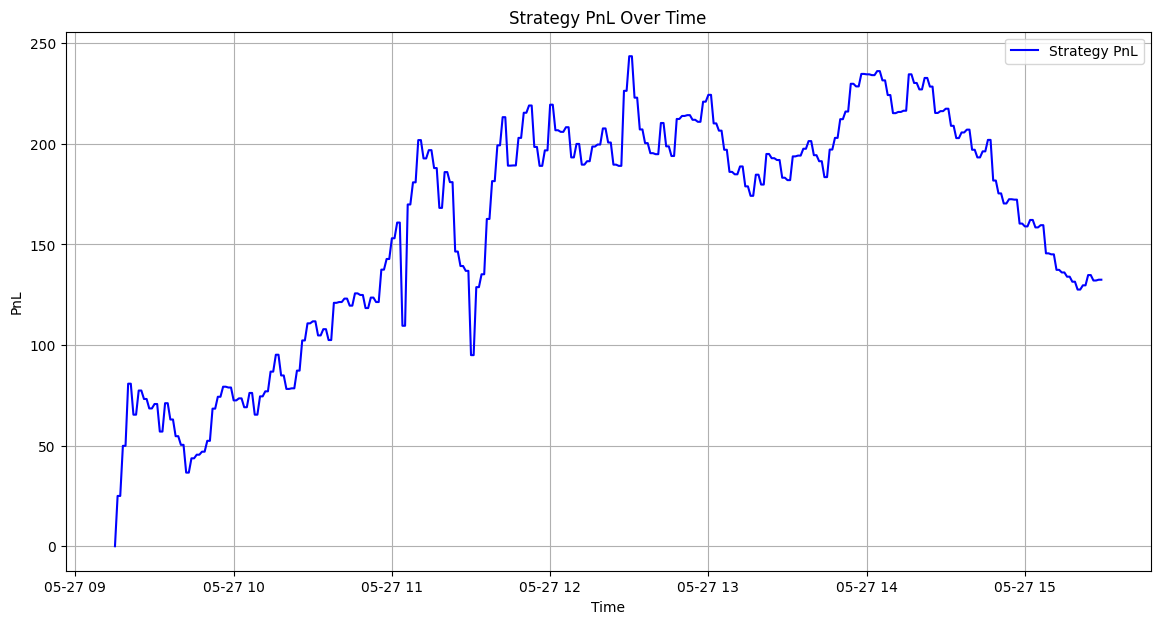

In [8]:
ex.plot_results()

In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("/Users/sushrutkagde/Documents/Project_X/backtesting_framework/sample_strategy/trades.csv", parse_dates=["timestamp"])

# Initialize tracking variables
positions = []
realized_pnls = []
cumulative_pnl = 0

for i, row in df.iterrows():
    price = row["order_price"]
    qty = row["quantity"]
    typ = row["type"]
    ts = row["timestamp"]
    
    if typ == "BUY":
        positions.append((price, qty))  # Store buy price and quantity
        realized_pnls.append(cumulative_pnl)
    elif typ == "SELL":
        sell_price = price
        qty_to_sell = qty
        pnl = 0
        
        while qty_to_sell > 0 and positions:
            buy_price, buy_qty = positions.pop(0)
            matched_qty = min(qty_to_sell, buy_qty)
            
            # Compute PnL
            pnl += matched_qty * (sell_price - buy_price)
            qty_to_sell -= matched_qty
            
            if buy_qty > matched_qty:
                positions.insert(0, (buy_price, buy_qty - matched_qty))

        cumulative_pnl += pnl
        realized_pnls.append(cumulative_pnl)
    else:
        raise ValueError(f"Unknown order type: {typ}")

# Add new column
df["realized_pnl"] = realized_pnls

# Drop the incorrect PnL columns and print final dataframe
df.drop(columns=["pnl"], inplace=True)
# print(df)
df


In [18]:
def calculate_realized_pnl():
    trades = pd.read_csv("/Users/sushrutkagde/Documents/Project_X/backtesting_framework/sample_strategy/trades.csv", parse_dates=["timestamp"])
    realized_pnl = 0.0
    pnl_history = []
    long_queue = []   # stores (price, quantity) of buys
    short_queue = []  # stores (price, quantity) of sells (shorts)

    for trade in trades.itertuples():
        qty = trade.quantity
        price = trade.order_price
        side = trade.type.upper()  # "BUY" or "SELL"

        if side == "BUY":
            # First, cover any short positions
            while qty > 0 and short_queue:
                short_price, short_qty = short_queue[0]
                match_qty = min(qty, short_qty)
                pnl = (short_price - price) * match_qty  # short: sell high, buy low
                realized_pnl += pnl

                if match_qty == short_qty:
                    short_queue.pop(0)
                else:
                    short_queue[0] = (short_price, short_qty - match_qty)

                qty -= match_qty

            # Remaining quantity is a new long position
            if qty > 0:
                long_queue.append((price, qty))

        elif side == "SELL":
            # First, close any long positions
            while qty > 0 and long_queue:
                long_price, long_qty = long_queue[0]
                match_qty = min(qty, long_qty)
                pnl = (price - long_price) * match_qty  # long: buy low, sell high
                realized_pnl += pnl

                if match_qty == long_qty:
                    long_queue.pop(0)
                else:
                    long_queue[0] = (long_price, long_qty - match_qty)

                qty -= match_qty

            # Remaining quantity is a new short position
            if qty > 0:
                short_queue.append((price, qty))

        pnl_history.append(realized_pnl)

    trades['realized_pnl'] = pnl_history
    print("Total pnl : {}".format(realized_pnl))
    return trades


In [6]:
from kiteconnect import KiteConnect
import pandas as pd
import os
kite = KiteConnect(os.getenv("api_key"), os.getenv("access_token"))
df=(pd.DataFrame(kite.instruments("NFO")))
df.to_csv("instruments_NFO.csv", index=False)


In [4]:
ex.plot_results()

KeyError: 'strategy_pnl'

<Figure size 1400x700 with 0 Axes>